# Transfer learning dog breed image classifier using Image generators, data augmentation, and fine-tuning

This is an extension of the work done by Jeremy Jordan [here](https://github.com/jeremyjordan/dog-breed-classifier). The goal of this work is to make a dog breed image classifier that is accurate on our unique and small dataset with little work. In this notebook you will learn about the following (italic items are new material compared to Jeremy's work).

- **Multiclass image classification** - image data organization, loading, preprocessing, and general pipelines
- **Imagenet models** - see how to use pre-trained models (from keras)
- **Transfer learning** - adjusting pre-trained models for accurate modeling of small datasets
- ***Image data generators*** - load, preprocess, categorize, and batch train your image data with little memory usage
- ***Automatic Image augmentation*** - increasing effective dataset size and model accuracy using image generator augmentation
- ***Fine-tuning*** - pushing transfer learning accuracy to it's limit

We'll employ functions from the following packages:
- numpy
- pandas
- scikit-learn
- keras/tensorflow

The data for the project is available [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)



# Data exploration

The train, validation, and test image sets are stored in a nested folder structure with class labels as folder names like so:

![test](folder_structure.png)

## Files and targets

To begin exploring the data, let's use sklearn's load_files function which is built to extract target labels based on nested folder structures like we have.

In [1]:
from sklearn.datasets import load_files
import os

data_path = r'C:\Users\jasonros\Downloads\dogImages'

train_data_files = load_files(os.path.join(data_path,'train'),
                              random_state = 1,
                              load_content = False)
train_data_files.keys()

dict_keys(['filenames', 'target_names', 'target', 'DESCR'])

load_files does not actually load the data when `load_content = False`, it's just a convenient way to generate a list of all the files and a categorical target array ready for training. Let's see what each it looks like:

In [2]:
print('Filenames shape is {}'.format(train_data_files['filenames'].shape))
print('The first couple filenames are', train_data_files['filenames'][:2])
print('Target shape is ', train_data_files['target'].shape)
print('The first couple targets are ', train_data_files['target'][:2])
print('The length of target_names is ', len(train_data_files['target_names']))
print('The target names for the first two targets are',
      [train_data_files['target_names'][x] for x in train_data_files['target'][:2]])

Filenames shape is (6680,)
The first couple filenames are ['C:\\Users\\jasonros\\Downloads\\dogImages\\train\\036.Briard\\Briard_02553.jpg'
 'C:\\Users\\jasonros\\Downloads\\dogImages\\train\\005.Alaskan_malamute\\Alaskan_malamute_00313.jpg']
Target shape is  (6680,)
The first couple targets are  [35  4]
The length of target_names is  133
The target names for the first two targets are ['036.Briard', '005.Alaskan_malamute']


So `filenames` contains the full paths to the image files whereas `targets` has already become an indexed set of labels based on the folder names. `target_names` retains those folder names allowing conversion of the indexed target labels back to dog breeds.


## Data size and Sampling Bias
It looks like we have 133 breeds of dogs to train for with only 6680 images, so there's not going to be a lot of examples for each class. Let's see how evenly distributed the samples are among the 133 breeds. To do this I use the `target_name` as a dictionary based on the index values in the `target` array to convert it to a 6680 long distribution of dog breed names.

In [3]:
train_breed_samples = [train_data_files['target_names'][x].split('.')[1] for x in train_data_files['target']]
train_breed_samples[:10]

['Briard',
 'Alaskan_malamute',
 'Border_terrier',
 'Cardigan_welsh_corgi',
 'Mastiff',
 'Cavalier_king_charles_spaniel',
 'Kerry_blue_terrier',
 'Chihuahua',
 'Briard',
 'Belgian_malinois']

Let's visualize all these samples using a bar chart to see our sampling distribution

minimum breed samples: 26 for Norwegian_buhund
maximum breed samples: 77 for Alaskan_malamute


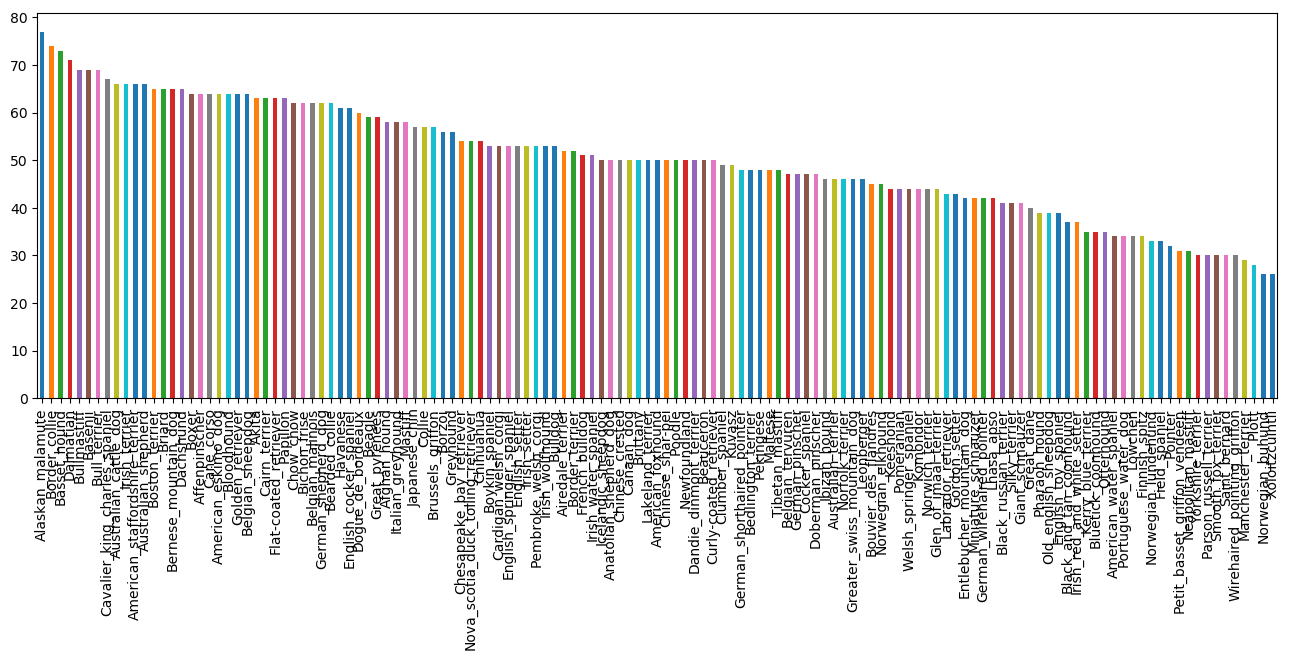

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('default')
import pandas as pd

train_breed_series = pd.Series(train_breed_samples)
train_breed_counts = train_breed_series.value_counts()
train_breed_counts.plot.bar(figsize = (16,5))
print('minimum breed samples:', train_breed_counts.min(),'for',train_breed_counts.idxmin())
print('maximum breed samples:', train_breed_counts.max(),'for',train_breed_counts.idxmax())

As expected, with the ratio of classes to instances, we do have a lot of samples for each class. None more than 77 and only 26 for Xoloitzcuintli. In a normal classifier situation, this isn't considered a large dataset which is why we will employ transfer learning to use pre-trained image feature extractors to boost our learning rate and accuracy. 

## Data structure

Before setting up our model, let's see what the image data actually looks like. Using keras image loader and our list of filenames, I write a function below that displays an image which we will reuse later and another to call it on a random training image and print its pixel dimensions.

In [5]:
from keras.preprocessing import image
import numpy as np

def show_image(path, print_size = False):
    img = image.load_img(path)
    if print_size:
        print('Image size', img.size)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def show_random():
    i = np.random.randint(0,len(train_data_files['filenames']))
    show_image(train_data_files['filenames'][i], print_size = True)
    print(os.path.basename(train_data_files['filenames'][i]))

Using TensorFlow backend.


Image size (537, 448)


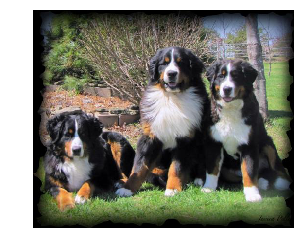

Bernese_mountain_dog_01692.jpg


In [6]:
show_random()

Image size (350, 355)


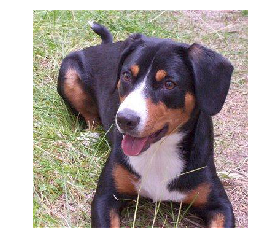

Entlebucher_mountain_dog_04576.jpg


In [7]:
show_random()

It looks like we're working with relatively high quality, full color images of dogs in various situations (indoors and outdoors). The dimensions of the images does not look to be consistent so we will need to restrict that in our image generator below. Also the size of the images are a bit large which could cause slow model learning, so we will likely want to reduce it down. A standard image training size is `224 x 224`, so let's go with that to solve both our problems here. 

In [8]:
image_size = 224

# Transfer learning model

For a comprehensive rundown of transfer learning similar to what I will show below, check out [Dipanjan's post](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)

In essence, transfer learning is when we load a pre-trained model and freeze those weights then train new layers on top of the model that as appropriate to the task at hand. In our case we will load deep CNN models from kera's applications package pre-trained on ~14 million images from the image-net project. There's actually a few variations of transfer learning of which we will explore two in this notebook:

1. **Freeze entire base model**: this is appropriate when your dataset is small and the base model solves a similar problem (such as object recognition of imagenet being similar to dog breed recogntion)
2. **Un-freeze some of base model layers - Fine-tuning**: This is useful to increase model accuracy when your dataset is not small but you are still solving a similar problem as the base model.
3. **Retrain entire base model**: This is still transfer learning because we are not starting with random weights but we are allowing the entire stack of layers to train. You would need a good sized dataset and be careful about overfitting in this scenario. I will not cover this topic in this notebook.

## Imagenet and dog detector

First let's talk about imagenet and show how a fully trained imagenet model can be used to detect if a dog is in an image. [Imagenet](http://www.image-net.org/) is a public database of ~14 million labeled images that many deep CNN classifiers and other computer vision models use to train on. 

Below I import a fully trained [Xception network](https://arxiv.org/abs/1610.02357). Xception is a recent (April 2017) CNN model that despite it's simple, easy to describe architecture has outperformed many of the other networks. Its author is the same as Keras and it is powering many of Google's mobile vision applications. [see here for a nice rundown on various deep CNN architectures](https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41) and [see here for the paper describing xception](https://arxiv.org/pdf/1610.02357.pdf). With it's top layer intact, this model will output 1000 class label probabilities. Labels between 151 and 268 inclusive are dogs so lets make a method that returns true if the max prediction is within that range. For documentation on keras applications [go here](https://keras.io/applications/)

In [9]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocessor_xception

preprocessor = preprocessor_xception

image_net_trained = Xception(include_top=True,
                             weights = 'imagenet',
                             input_shape = (image_size,image_size,3)
                            )

Before we can predict with this network, we need to convert our image files into 4D numpy arrays, which is handled by the path_to_tensor method below. Note the xception preprocess_input method used on the final array, this scales the image data to the proper format for the xception model.

In [10]:
def path_to_tensor(img_path, display_image = False):
    if display_image:
        show_image(img_path)
    img = image.load_img(img_path, target_size=(image_size, image_size))
    img = image.img_to_array(img)
    img  = np.expand_dims(img, axis=0) # adds a 4th dimension that is essentially batchsize=1
    return preprocessor(img)

def dog_detector(path, display_image = False):
    img = path_to_tensor(path, display_image=display_image)
    prediction = image_net_trained.predict(img).argmax()
    return ((prediction <= 268) & (prediction >= 151))

First let's see what dog_detector returns for one of our training dog images

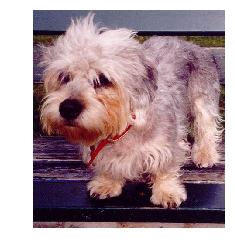

True


In [11]:
print(dog_detector(train_data_files['filenames'][34], display_image = True))

Yay, we got True. Now let's try an image of a human, myself, which is found in the my_images folder in the working directory

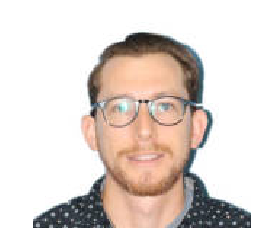

False


In [12]:
print(dog_detector(r'my_images/badge photo.jpg',display_image = True))

So our dog_detector method using the full xception pre-trained on imagenet seems to be working. I will not go into a analysis of it's accuracy because it's a little bit of a tangent here so just trust me that it's quite good at making this prediction and we will see more examples of it later.



## Image Generators

As we saw above, one way to process our images is to load them into memory then send them into the model. We did this for just a single image to get a prediction, but during training we need to load all the images. If you had a large dataset and not a lot of system memory to work with, this can really bog down your PC. The alternative is to use an image generator which loads the images on the fly in batches as the keras model runs through training. Below I setup an image generator for each of the train, validation, and test datasets.

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevents error when generator opens certain images

datagen = ImageDataGenerator(preprocessing_function = preprocessor)

train_generator = datagen.flow_from_directory(
        os.path.join(data_path,'train'),
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical',
        seed=14)

valid_generator = datagen.flow_from_directory(
        os.path.join(data_path,'valid'),
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical',
        seed=14)

test_generator = datagen.flow_from_directory(
        os.path.join(data_path,'test'),
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical',
        seed=14)

num_classes = len(train_generator.class_indices)
targets = pd.Series([x.split('.')[1] for x in list(train_generator.class_indices.keys())])
targets = targets.apply(lambda x: x.replace('_',' '))

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 836 images belonging to 133 classes.


## Transfer layer

Now we're ready to setup our transfer model. Below I import a pre-trained imagenet xception network with global average pooling of it's output, which flattens the output so it's ready for our top classifying layer(s).

In [14]:
from keras.applications.xception import Xception
transfer_layer_xception = Xception(include_top=False,
                                   weights = 'imagenet',
                                   pooling='avg',
                                   input_shape = (image_size,image_size,3))

Now we freeze all the layers in the transfer model so they do not get trained:

In [15]:
for layer in transfer_layer_xception.layers:
    layer.trainable = False

## Top layer model and training

Below we build up a keras sequential model starting with the transfer layer, adding a single densely connected layer the size of our number of dog breeds which is our classifying layer. The softmax activation outputs probabilities of every dog breed label, the highest of which we will consider the guess of the model. 

I also add early stopping callbacks and model checkpoints to save time by stopping if the training veers off course and save the best epoch weights according to validation accuracy so we can reload this later.

NOTE: If you don't have a powerful GPU, the training can take a long time, so feel free to skip down to the cell where I load the weights and run that cell before continuing.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

top_model = Sequential()
top_model.add(transfer_layer_xception)
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience = 15)
cb_checkpointer = ModelCheckpoint(filepath = 'best_xception.hdf5', monitor = 'val_acc',
                                  save_best_only = True, mode = 'auto')

In [17]:
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 21,133,997
Trainable params: 272,517
Non-trainable params: 20,861,480
_________________________________________________________________


The summary shows that the trainable parameters are only the 272514 from the top dense layer we added, confirming the deep xception layer will remain freezed in the imagenet weights we loaded previously.

In [18]:
NUM_EPOCHS = 50

fit_history = top_model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs = NUM_EPOCHS,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[cb_checkpointer,cb_early_stopper],
        verbose=1
)

Epoch 1/50
279/279 [==============================] - 67s 241ms/step - loss: 0.7141 - acc: 0.8135 - val_loss: 0.7633 - val_acc: 0.8000
Epoch 2/50
279/279 [==============================] - 66s 235ms/step - loss: 0.5942 - acc: 0.8371 - val_loss: 0.8282 - val_acc: 0.7976
Epoch 3/50
279/279 [==============================] - 64s 229ms/step - loss: 0.5045 - acc: 0.8548 - val_loss: 0.8402 - val_acc: 0.8096
Epoch 4/50
279/279 [==============================] - 65s 231ms/step - loss: 0.4542 - acc: 0.8680 - val_loss: 0.8179 - val_acc: 0.8192
Epoch 5/50
279/279 [==============================] - 65s 232ms/step - loss: 0.3986 - acc: 0.8887 - val_loss: 0.8672 - val_acc: 0.8180
Epoch 6/50
279/279 [==============================] - 65s 231ms/step - loss: 0.3694 - acc: 0.8944 - val_loss: 0.8466 - val_acc: 0.8228
Epoch 7/50
279/279 [==============================] - 64s 229ms/step - loss: 0.3388 - acc: 0.9083 - val_loss: 0.9050 - val_acc: 0.8096
Epoch 8/50
279/279 [==============================] - 6

Now let's reload the best model and check the accuracies on all our generators

In [18]:
top_model.load_weights('best_xception.hdf5')

In [19]:
def print_accuracies(train_gen = train_generator):
    loss, acc = top_model.evaluate_generator(train_gen,verbose=1)
    print('Train accuracy is {:.3f}'.format(acc))
    loss, acc = top_model.evaluate_generator(valid_generator,verbose=1)
    print('Validation accuracy is {:.3f}'.format(acc))
    loss, acc = top_model.evaluate_generator(test_generator,verbose=1)
    print('Test accuracy is {:.3f}'.format(acc))

In [23]:
print_accuracies()

279/279 [==============================] - 60s 217ms/step
Train accuracy is 0.912
35/35 [==============================] - 7s 202ms/step
Validation accuracy is 0.836
35/35 [==============================] - 8s 223ms/step
Test accuracy is 0.833


With our training accuracy higher than both validation and test, we are clearly overfitting to the training data. Let's take a look at the trend by plotting the fit_history

In [20]:
def plot_fit_history(fit_hist):
    fit_hist_df = pd.DataFrame(fit_hist.history).reset_index()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fit_hist_df.plot.line('index',['acc','val_acc'],ax = ax1)
    fit_hist_df.plot.line('index',['loss','val_loss'], ax = ax2)
    return fit_hist_df

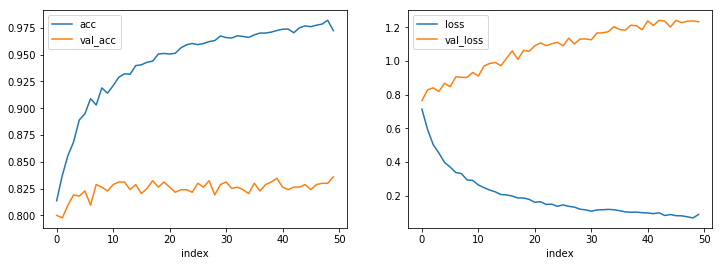

In [25]:
fit_history_df = plot_fit_history(fit_history)
fit_history_df['fit_type'] = 'simple'

Looks like we were overfitting very early on and even though our training accuracy was increasing, our validation loss was also increasing so the model was fitting validation data worse as it trained more. 

Let's attempt to reduce overfitting and possibly increase validation accuracy by adding another dense classifying layer followed by a dropout layer. Dropout of 0.5 means there's a 50% chance that each neuron output will be ignored from the previous layer which has a regularizing affect and reduces overfitting. 

In [29]:
top_model = Sequential()
top_model.add(transfer_layer_xception)
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience = 15)
cb_checkpointer = ModelCheckpoint(filepath = 'best_xception_dropout.hdf5', monitor = 'val_acc',
                                  save_best_only = True, mode = 'auto')

In [30]:
fit_history_dropout = top_model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs = NUM_EPOCHS,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[cb_checkpointer,cb_early_stopper],
        verbose=1
)

Epoch 1/50
279/279 [==============================] - 67s 242ms/step - loss: 3.4610 - acc: 0.2884 - val_loss: 1.0598 - val_acc: 0.6922
Epoch 2/50
279/279 [==============================] - 64s 230ms/step - loss: 1.7866 - acc: 0.5372 - val_loss: 0.8271 - val_acc: 0.7749
Epoch 3/50
279/279 [==============================] - 64s 229ms/step - loss: 1.3571 - acc: 0.6313 - val_loss: 0.8256 - val_acc: 0.7904
Epoch 4/50
279/279 [==============================] - 64s 228ms/step - loss: 1.1875 - acc: 0.6750 - val_loss: 0.8439 - val_acc: 0.7976
Epoch 5/50
279/279 [==============================] - 64s 231ms/step - loss: 1.0744 - acc: 0.6959 - val_loss: 0.7960 - val_acc: 0.8084
Epoch 6/50
279/279 [==============================] - 64s 229ms/step - loss: 0.9722 - acc: 0.7225 - val_loss: 0.8512 - val_acc: 0.8012
Epoch 7/50
279/279 [==============================] - 64s 229ms/step - loss: 0.9164 - acc: 0.7370 - val_loss: 0.8235 - val_acc: 0.8108
Epoch 8/50
279/279 [==============================] - 6

279/279 [==============================] - 61s 217ms/step
Train accuracy is 0.888
35/35 [==============================] - 7s 201ms/step
Validation accuracy is 0.830
35/35 [==============================] - 7s 203ms/step
Test accuracy is 0.821


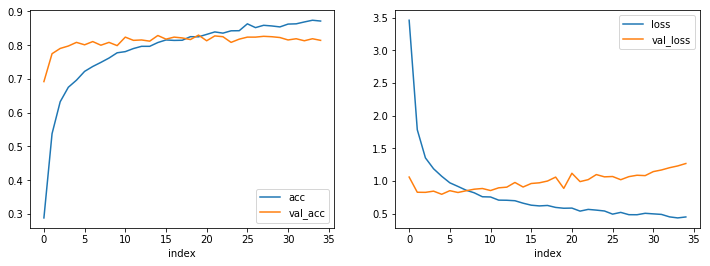

In [31]:
top_model.load_weights('best_xception_dropout.hdf5')
print_accuracies()
fit_history_dropout_df = plot_fit_history(fit_history_dropout)
fit_history_dropout_df['fit_type'] = 'with_dropout'

It looks like we cut down somewhat on the overfitting but in the end the validation and test accuracy was worse. Let's try a different tactic.

## Image Augmentation

Another way to reduce overfitting and increase model generalization accuracy is to employ image augmentation. Here we will modify our `train_generator` to implement some of keras built-in image augmentation abilities such as zoom_range, rotation_range, shifting, shearing, and horizontal flipping of the images. These augmentations get applied randomly on each batch so every epoch of training sees new augmentations. This artificially balloons our dataset size and prevents overfitting since we don't train on the same exact data each epoch. Hopefully with better generalization, the validation and test accuracy  will increase.

First, let's set up the new image generator

In [21]:

datagen_augmented = ImageDataGenerator(preprocessing_function = preprocessor,
                                       zoom_range=0.3,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

train_generator_augmented = datagen_augmented.flow_from_directory(
        os.path.join(data_path,'train'),
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical',
        seed=14)

Found 6680 images belonging to 133 classes.


In [22]:
top_model = Sequential()
top_model.add(transfer_layer_xception)
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_acc', patience = 20)
cb_checkpointer = ModelCheckpoint(filepath = 'best_xception_augment.hdf5', monitor = 'val_acc',
                                  save_best_only = True, mode = 'auto')

In [37]:
fit_history_augment = top_model.fit_generator(
        train_generator_augmented,
        steps_per_epoch=len(train_generator),
        epochs = 100,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[cb_checkpointer,cb_early_stopper],
        verbose=1
)

Epoch 1/100
279/279 [==============================] - 133s 476ms/step - loss: 2.5857 - acc: 0.4843 - val_loss: 0.7931 - val_acc: 0.7437
Epoch 2/100
279/279 [==============================] - 129s 462ms/step - loss: 1.2534 - acc: 0.6861 - val_loss: 0.7301 - val_acc: 0.7820
Epoch 3/100
279/279 [==============================] - 128s 460ms/step - loss: 1.0246 - acc: 0.7225 - val_loss: 0.7332 - val_acc: 0.8012
Epoch 4/100
279/279 [==============================] - 128s 459ms/step - loss: 0.9441 - acc: 0.7436 - val_loss: 0.7082 - val_acc: 0.8096
Epoch 5/100
279/279 [==============================] - 128s 460ms/step - loss: 0.9108 - acc: 0.7481 - val_loss: 0.7354 - val_acc: 0.8132
Epoch 6/100
279/279 [==============================] - 128s 458ms/step - loss: 0.8653 - acc: 0.7621 - val_loss: 0.7882 - val_acc: 0.8048
Epoch 7/100
279/279 [==============================] - 129s 462ms/step - loss: 0.8152 - acc: 0.7745 - val_loss: 0.7937 - val_acc: 0.8168
Epoch 8/100
279/279 [====================

In [23]:
top_model.load_weights('best_xception_augment.hdf5')

279/279 [==============================] - 62s 223ms/step
Train accuracy is 0.887
35/35 [==============================] - 7s 209ms/step
Validation accuracy is 0.849
35/35 [==============================] - 7s 208ms/step
Test accuracy is 0.831


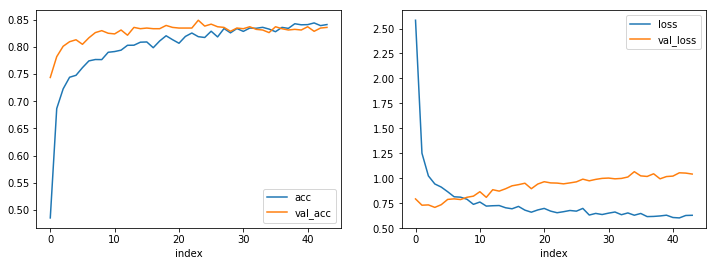

In [38]:
print_accuracies()
fit_history_augment_df = plot_fit_history(fit_history_augment)
fit_history_augment_df['fit_type'] = 'augmented'

A few things to notice:

1. The training epoch took about twice as long then the previous two models. This is likely do to the image augmentations being performed on the fly by the genrator.
2. Compared to the first model we built, the validation accuracy did improve marginally but the test accuracy mostly remained unchanged. 
3. We see little overfitting here even though we used the same model that originally showed a lot of overfitting. 

In the end, though, it seems we need to move on to the next tool in our transfer learning toolbox in order to improve our model.

# Fine-tuning model

Below I will show how we can explore the layers of the deep xception model and choose to unfreeze some of them to allow training. First let's print out every layer as well as it's trainable parameter.

In [24]:
for i, layer in enumerate(transfer_layer_xception.layers):
    print(i,layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_5 False
13 block2_pool False
14 batch_normalization_5 False
15 add_13 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_6 False
23 block3_pool False
24 batch_normalization_6 False
25 add_14 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_7 False
33 block4_pool False
34 batch_normalization_7 False
35 add_15 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepco

As with many deep CNNs for image tasks, the layers are grouped into blocks that perform essential functions, according to [Chollet's paper on Xception](https://arxiv.org/pdf/1610.02357.pdf) these blocks are grouped into three main flows:

![xception_flows](xception_blocks.png)

So it has 4 blocks for the input flow, 8 repeated blocks for the middle flow, and 2 blocks for the exit flow. As with most deep CNNs for image tasks, the first several blocks are performing feature extraction of elements such as edges while the later blocks are focusing on compiling those features to produce outputs for the task at hand. Let's start by opening up the whole exit flow for training which starts from layer 116.

In [25]:
for layer in transfer_layer_xception.layers[116:]:
    layer.trainable = True

In [26]:
for i, layer in enumerate(transfer_layer_xception.layers):
    print(i,layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_5 False
13 block2_pool False
14 batch_normalization_5 False
15 add_13 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_6 False
23 block3_pool False
24 batch_normalization_6 False
25 add_14 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_7 False
33 block4_pool False
34 batch_normalization_7 False
35 add_15 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepco

This time around, I'm not going to retrain the top layer from scratch. We can simply recompile our most recent `top_model` which to update the newly trainable layers and start the model off from a place of high accuracy. This prevents our exit flow layers from veering too far off in the beginning of training due to feeding untrained top layers. Another way we will ensure the model doesn't drift too far, too fast is to use a new optimizer with a lower training rate as seen below.

We'll also change the early stopping to monitor the val_loss this round because from experience the val_loss experiences nice reductions under fine-tuning and we want to capture an accurate model with minimum loss.

Finally we'll allow for 150 epochs to give the slower trained model plenty of time to mature.

In [27]:
from keras import optimizers

top_model.compile(optimizer= optimizers.SGD(lr=0.0002, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 20)
cb_checkpointer = ModelCheckpoint(filepath = 'best_xception_augment_finetuned116.hdf5', monitor = 'val_acc',
                                  save_best_only = True, mode = 'auto')

In [28]:
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 21,133,997
Trainable params: 7,060,901
Non-trainable params: 14,073,096
_________________________________________________________________


Here we see that the number of trainable parameters has increased according to our unfreezing of the xception exit flow blocks.

In [45]:
fit_history_finetune = top_model.fit_generator(
        train_generator_augmented,
        steps_per_epoch=len(train_generator),
        epochs = 150,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[cb_checkpointer,cb_early_stopper],
        verbose=1
)

Epoch 1/150
279/279 [==============================] - 138s 496ms/step - loss: 0.6118 - acc: 0.8344 - val_loss: 0.9286 - val_acc: 0.8467
Epoch 2/150
279/279 [==============================] - 129s 462ms/step - loss: 0.5518 - acc: 0.8493 - val_loss: 0.8947 - val_acc: 0.8515
Epoch 3/150
279/279 [==============================] - 128s 457ms/step - loss: 0.5217 - acc: 0.8525 - val_loss: 0.8780 - val_acc: 0.8479
Epoch 4/150
279/279 [==============================] - 128s 460ms/step - loss: 0.4941 - acc: 0.8499 - val_loss: 0.8464 - val_acc: 0.8479
Epoch 5/150
279/279 [==============================] - 127s 456ms/step - loss: 0.4804 - acc: 0.8566 - val_loss: 0.8386 - val_acc: 0.8527
Epoch 6/150
279/279 [==============================] - 128s 460ms/step - loss: 0.4480 - acc: 0.8629 - val_loss: 0.8250 - val_acc: 0.8539
Epoch 7/150
279/279 [==============================] - 128s 460ms/step - loss: 0.4633 - acc: 0.8622 - val_loss: 0.8164 - val_acc: 0.8539
Epoch 8/150
279/279 [====================

In [29]:
top_model.load_weights('best_xception_augment_finetuned116.hdf5')

279/279 [==============================] - 62s 221ms/step
Train accuracy is 0.913
35/35 [==============================] - 7s 209ms/step
Validation accuracy is 0.861
35/35 [==============================] - 7s 206ms/step
Test accuracy is 0.843


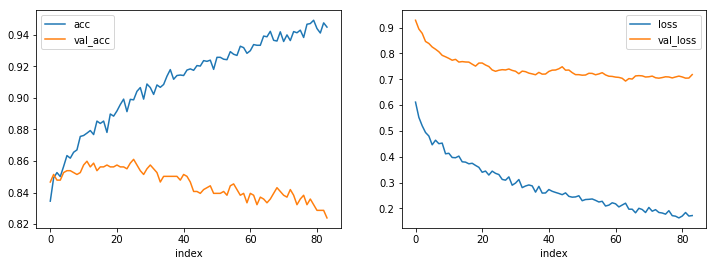

In [46]:
print_accuracies()
fit_history_finetune_df = plot_fit_history(fit_history_finetune)
fit_history_finetune_df['fit_type'] = 'fine_tune'

Let's combine all the fit histories together to see how each training session affected the outcome

In [ ]:
fit_history_dfs = [fit_history_df, fit_history_dropout_df, fit_history_augment_df, fit_history_finetune_df]
full_fit_history_df = pd.concat(fit_history_dfs)
full_fit_history_df.drop('index',axis=1)
full_fit_history_df['EPOCHS'] = list(range(len(full_fit_history_df)))

In [ ]:
# save fit history to csv for future use to avoid re-training
full_fit_history_df.to_csv('full_xception_fit_history.csv')

Text(150,0.9,'loss at max val_acc')

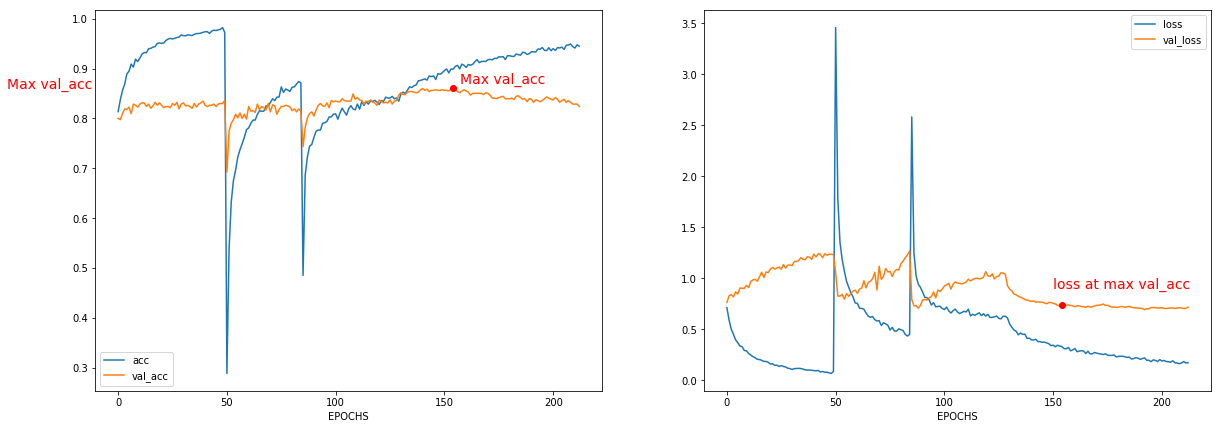

In [54]:
full_fit_history_df = pd.read_csv('full_xception_fit_history.csv')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
max_acc = full_fit_history_df['val_acc'].max()
max_acc_index = full_fit_history_df['val_acc'].idxmax()
max_acc_epoch = full_fit_history_df['EPOCHS'].iloc[max_acc_index]
loss_at_max_acc = full_fit_history_df['val_loss'].iloc[max_acc_index]
full_fit_history_df.plot.line('EPOCHS',['acc','val_acc'],ax = ax1)
full_fit_history_df.plot.line('EPOCHS',['loss','val_loss'], ax = ax2)
ax1.plot(max_acc_epoch,max_acc, marker = 'o',color='red',markersize = 6)
ax1.text(max_acc_epoch+3,max_acc+.01,'Max val_acc',color='red',size = 14)
ax2.plot(max_acc_epoch,loss_at_max_acc, marker = 'o',color='red',markersize = 6)
ax2.text(150,.9,'loss at max val_acc',color='red',size = 14)

It looks like our fine-tuned model squeezed out a little more validation accuracy than the rest, while also greatly reducing the validation loss. This model is still overfitting a little but with an accuracy of >85% on our small dataset with 133 classes, this is quite a good result thanks to transfer learning and fine-tuning.

## Exploring bad predictions

One final thing we can do is investigate the images that the model is not predicting correctly. Let's build a function that plots images of samples and their incorrectly predicted training breeds. We'll focus on the test set since it's smaller and has a similar performance to validation set.

First let's gather the test image paths and run them through the model and categorize them as pass or fail depending on accurate breed predictions

In [113]:
test_data_files = load_files(os.path.join(data_path,'test'),random_state = 1)
list_image_arrays = [path_to_tensor(img_path) for img_path in test_data_files['filenames']]
full_test_tensor = np.vstack(list_image_arrays)
print('full test tensor shape:',full_test_tensor.shape)

full test tensor shape: (836, 224, 224, 3)


In [114]:
test_predictions = top_model.predict(full_test_tensor,verbose=1)

836/836 [==============================] - 3s 4ms/step


In [115]:
print('test predictions shape',test_predictions.shape)
print('test actual shape',test_data_files['target'].shape)

test predictions shape (836, 133)
test actual shape (836,)


test_predictions has 133 different probabilities for each sample. We want to get the index of the highest probability (the guess) to compare to the actual breeds which is already in that format. This can be easily accomplished with numpy's `argmax()` function which finds the index of the maximum value of an array. For the 2D test_predictions array, we get the max along the columns using `axis=1`

In [116]:
test_predictions_index = np.argmax(test_predictions,axis = 1)
test_predictions_index.shape

(836,)

Now let's find the where this is different from the actual breeds using a boolean comparison of the class integers. 

In [117]:
predictions_boolean = np.equal(test_predictions_index,test_data_files['target'])
print('first 10 (predicted == actual) boolean:',predictions_boolean[:10])

first 10 (predicted == actual) boolean: [False  True  True  True  True  True  True  True  True  True]


For each False value in `predictions_boolean`, let's display the test image and a random sample of the falsely predicted breed from the training set to see if we can tease out why the model is making bad predictions

In [118]:
def show_image_small(path):
    img = image.load_img(path)
    fig = plt.figure(figsize = (3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def show_random_dog(breed, small = False):
    choices = [file for file in train_data_files['filenames'] if breed.replace(' ','_') in file]
    choice_path = choices[np.random.randint(0,len(choices))]
    if small:
        show_image_small(choice_path)
    else:
        show_image(choice_path)

Test Sample 0


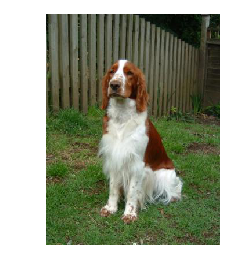

Actual breed Welsh springer spaniel
Predicted breed Irish red and white setter
Train example of predicted breed


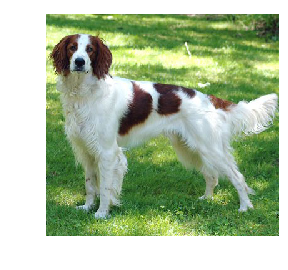

Test Sample 11


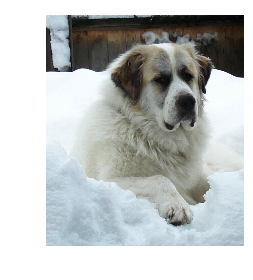

Actual breed Great pyrenees
Predicted breed Saint bernard
Train example of predicted breed


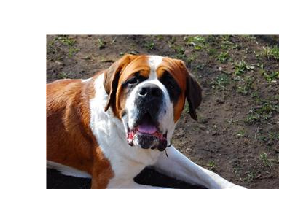

Test Sample 21


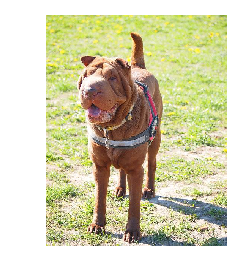

Actual breed Chinese shar-pei
Predicted breed Nova scotia duck tolling retriever
Train example of predicted breed


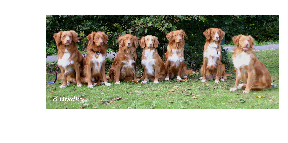

Test Sample 23


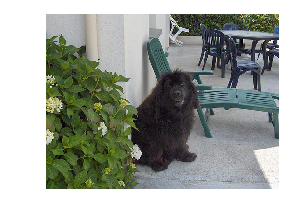

Actual breed Newfoundland
Predicted breed Briard
Train example of predicted breed


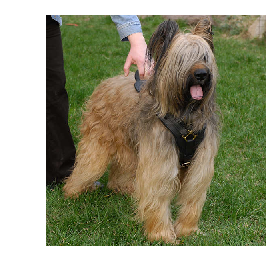

Test Sample 26


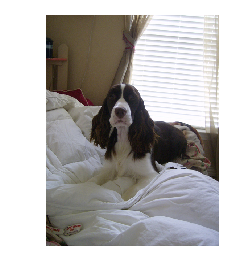

Actual breed English springer spaniel
Predicted breed Cavalier king charles spaniel
Train example of predicted breed


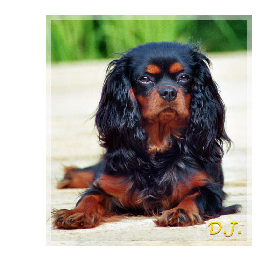

Test Sample 37


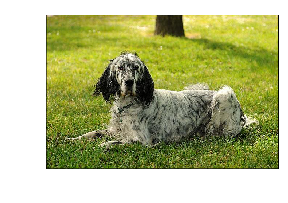

Actual breed English setter
Predicted breed Petit basset griffon vendeen
Train example of predicted breed


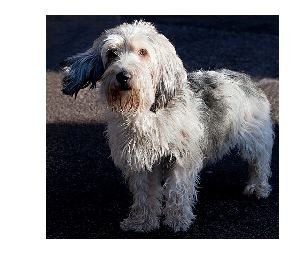

Test Sample 56


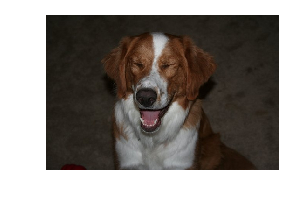

Actual breed Irish red and white setter
Predicted breed Welsh springer spaniel
Train example of predicted breed


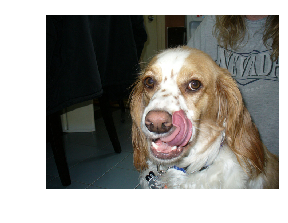

In [119]:
num_displayed = 0
for sample_index,b in enumerate(predictions_boolean):
    if not b:
        print('Test Sample',sample_index)
        show_image_small(test_data_files['filenames'][sample_index])
        breed_actual = targets[test_data_files['target'][sample_index]]
        print('Actual breed',breed_actual)
        
        breed_guess = targets[test_predictions_index[sample_index]]
        print('Predicted breed',breed_guess)        
        print('Train example of predicted breed')
        show_random_dog(breed_guess,small = True)
        num_displayed+=1
    if num_displayed > 6:
        break

From these examples it seems like the model falls short in two main ways:

1. For dogs with similar hair and color patterns but only slightly different physical structure.
2. For images with dogs in complex environments, like indoors surrounded by other objects, or in unevenly lit situations like a bright window behind the dog, sitting in bright snow, or bright sunlight on a portion of the dog.

It's possibly our dataset just isn't clean enough to push the accuracy much higher. Future tactics might be to 

1. Feed the images through a segmentation model that isolates the location of the subject from the background, crops them out, and only trains/predicts off the subject.
2. Explore more image augmentations and fine-tuning of deeper xception layers.
3. Explore other deep CNN models that might be better suited for the images in our dataset. 

# Predicting my images

Now that we have a relatively accurate model we can have a little fun and see how it works both on some of my friend's dog images as well as images of humans (me, friends, celebrities). Below I write a prediction method that takes a supplied image path, uses the dog detector we wrote in the beginning to determine if it's a dog or not, predicts the dog breed using our fine-tuned model, displays a random example of the breed, and also displays the top three predicted breeds from the fully trained imagenet model which as we discussed previously has 117 dog breeds classified. As we reminder, we have 133 different breeds but they're not inclusive of all 117 from imagenet as we'll see below.

Not only is this a cute application of the model, it can actually provide us a little more insight on what features the model is using to choose breeds. So let's see what happens.

In [85]:
from keras.applications.resnet50 import decode_predictions as resnet50_decode_predictions

def make_prediction(path, decode_predictions = resnet50_decode_predictions):    
    print('loading image')
    img = path_to_tensor(path, display_image = True)
    
    # first see if it's a dog or not
    if dog_detector(path):
        print("It looks like you're a dog, let's see which breed!")
        give_example = True
    else:
        print("You don't look like a dog, maybe a human? Let's see what kind of dog you would be!")
        give_example = True

    print('According to my model, you are a:')    
    prediction = top_model.predict(img)
    breed = targets[prediction.argmax()]
    print(breed)
    if give_example:
        print("Below is a prime example of your breed")
        show_random_dog(breed)
    
    # Also find imagenets dog breed predictions:
    imagenet_pred = image_net_trained.predict(img)
    # set non-dog predictions to zero so decoder picks top 3 dogs
    dog_preds = imagenet_pred
    dog_preds[0,0:151] = 0
    dog_preds[0,269:] = 0
    print('And your top 3 Imagenet dog breed predictions are...')
    print([x[1] for x in decode_predictions(dog_preds, top=3)[0]])

In [57]:
def random_test():
    i = np.random.randint(0,len(test_data_files['filenames']))
    print('Running prediction for', os.path.basename(test_data_files['filenames'][i]))
    pred = make_prediction(test_data_files['filenames'][i])
    return pred

In [90]:
pred = random_test()

loading image


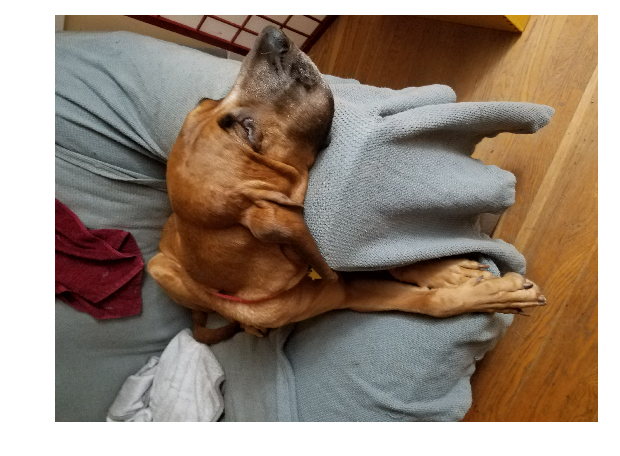

It looks like you're a dog, let's see which breed!
According to my model, you are a:
Bloodhound
Below is a prime example of your breed


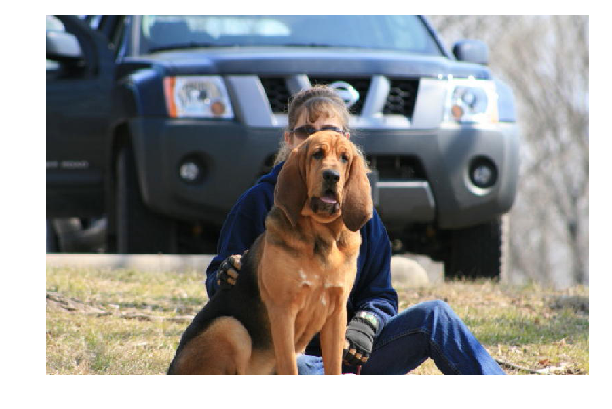

And your top 3 Imagenet dog breed predictions are...
['bloodhound', 'redbone', 'Rhodesian_ridgeback']


In [91]:
make_prediction(r'my_images\homer.jpg')

loading image


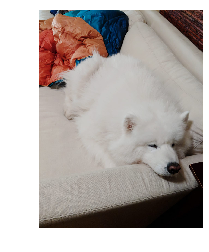

It looks like you're a dog, let's see which breed!
According to my model, you are a:
006.American eskimo dog
Below is a prime example of your breed


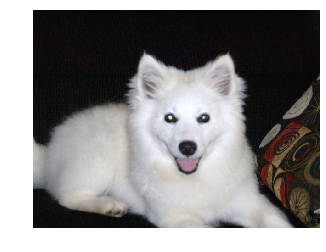

And your top 3 Imagenet dog breed predictions are...
['Samoyed', 'Pomeranian', 'keeshond']


In [72]:
make_prediction(r'my_images/unknownfluffdog.jpg')

This is an example where the imagenet model makes a better prediction only because we did not have Samoyeds as a breed in our 133 trained targets.

How about a difficult example of a dog wearing a costume?

loading image


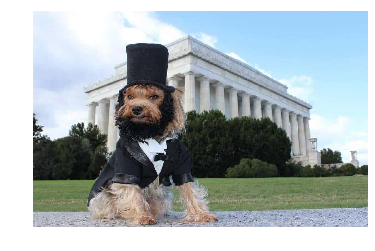

It looks like you're a dog, let's see which breed!
According to my model, you are a:
133.Yorkshire terrier
Below is a prime example of your breed


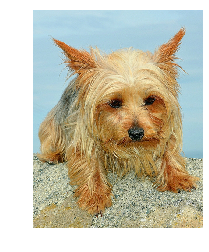

And your top 3 Imagenet dog breed predictions are...
['Airedale', 'Lakeland_terrier', 'Yorkshire_terrier']


In [73]:
make_prediction(r'my_images\abedoggon.jpg')

I think my model does a better job here than imagenet. If you look up an Airdale, they are big dogs with large snouts, definitely not the Abraham doggo we see in the image. I think Yorkshire terrier looks right and is the 3rd guess of imagenet. 

Ok let's move on to human images! for me.

loading image


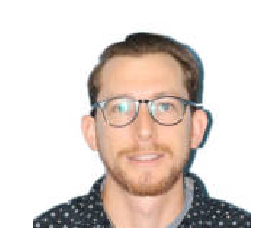

You don't look like a dog, maybe a human? Let's see what kind of dog you would be!
According to my model, you are a:
056.Dachshund
Below is a prime example of your breed


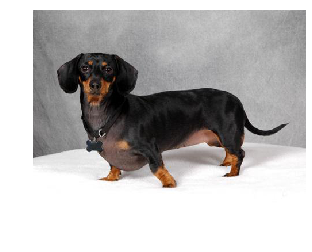

And your top 3 Imagenet dog breed predictions are...
['clumber', 'Kerry_blue_terrier', 'Afghan_hound']


In [74]:
make_prediction(r'my_images\badge photo.jpg')

Cool. Not sure exactly how it decided this, maybe my hair color and more reddish beard color like the dark head and light brown of the dachshund?

loading image


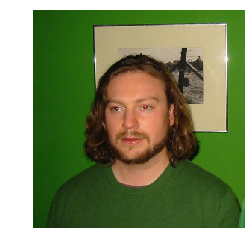

You don't look like a dog, maybe a human? Let's see what kind of dog you would be!
According to my model, you are a:
125.Portuguese water dog
Below is a prime example of your breed


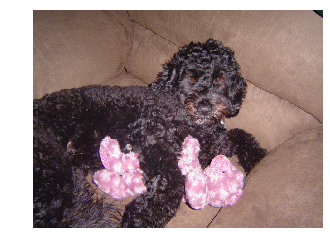

And your top 3 Imagenet dog breed predictions are...
['Shetland_sheepdog', 'toy_poodle', 'Kerry_blue_terrier']


In [82]:
make_prediction(r'my_images\eddievedder.jpg')

OK, here it seems the model is focusing mostly on the hair. Let's try an extreme example.

loading image


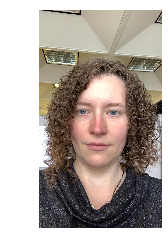

You don't look like a dog, maybe a human? Let's see what kind of dog you would be!
According to my model, you are a:
088.Irish water spaniel
Below is a prime example of your breed


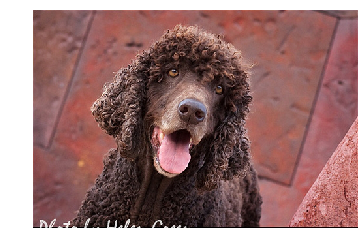

And your top 3 Imagenet dog breed predictions are...
['Irish_water_spaniel', 'Kerry_blue_terrier', 'toy_poodle']


In [76]:
make_prediction(r'my_images\jenn.jpg')

I think this prediction is just perfect. The model is obviously heavily influenced by my friend Jenn's hair and chose the very similarly furred Irish water spaniel. Imagenet seems to be similar. 

loading image


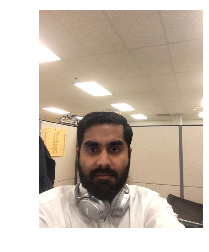

You don't look like a dog, maybe a human? Let's see what kind of dog you would be!
According to my model, you are a:
038.Brussels griffon
Below is a prime example of your breed


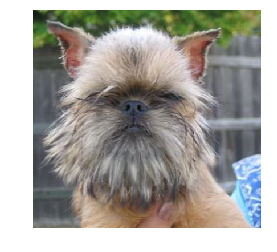

And your top 3 Imagenet dog breed predictions are...
['Lhasa', 'Shih-Tzu', 'beagle']


In [77]:
make_prediction(r'my_images\hitesh.jpg')

loading image


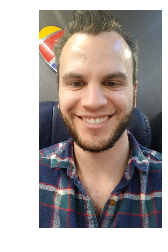

You don't look like a dog, maybe a human? Let's see what kind of dog you would be!
According to my model, you are a:
058.Dandie dinmont terrier
Below is a prime example of your breed


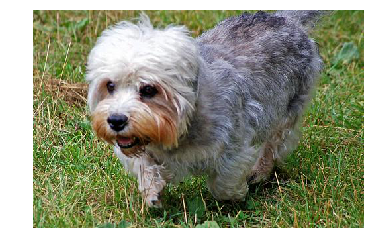

And your top 3 Imagenet dog breed predictions are...
['miniature_pinscher', 'Lhasa', 'Boston_bull']


In [78]:
make_prediction(r'my_images\alex2.jpg')

loading image


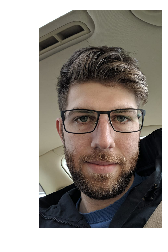

You don't look like a dog, maybe a human? Let's see what kind of dog you would be!
According to my model, you are a:
100.Lowchen
Below is a prime example of your breed


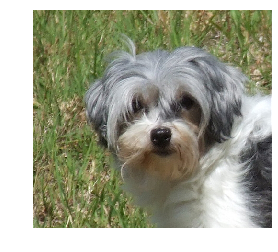

And your top 3 Imagenet dog breed predictions are...
['miniature_pinscher', 'beagle', 'Lhasa']


In [79]:
make_prediction(r'my_images\ian.jpg')

loading image


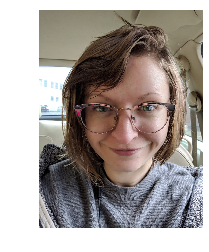

You don't look like a dog, maybe a human? Let's see what kind of dog you would be!
According to my model, you are a:
056.Dachshund
Below is a prime example of your breed


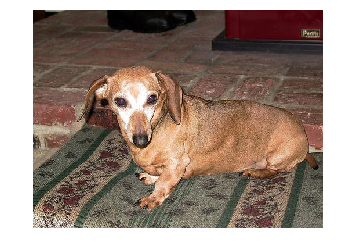

And your top 3 Imagenet dog breed predictions are...
['Lhasa', 'toy_poodle', 'miniature_poodle']


In [80]:
make_prediction(r'my_images\amanda.jpg')

# Backup/Legacy code below

In [ ]:
NUM_EPOCHS = 30

def build_and_train(transfer_layer, train_gen, valid_gen, checkpoint_name, include_dense=False,
                    dense_neurons = 256, dropout_amount = 0.5, patience = 3):
    num_classes
    model = Sequential()
    model.add(transfer_layer)
    if include_dense:
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout_amount))
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout_amount))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    # Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
    from keras.callbacks import EarlyStopping, ModelCheckpoint

    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = patience)
    cb_checkpointer = ModelCheckpoint(filepath = checkpoint_name, monitor = 'val_loss',
                                      save_best_only = True, mode = 'auto')
    
    fit_history = model.fit_generator(
            train_gen,
            steps_per_epoch=len(train_gen),
            epochs = NUM_EPOCHS,
            validation_data=valid_gen,
            validation_steps=len(valid_gen),
            callbacks=[cb_checkpointer,cb_early_stopper],
            verbose=1
    )
    return model, fit_history

In [58]:
targets

0                           Affenpinscher
1                            Afghan hound
2                        Airedale terrier
3                                   Akita
4                        Alaskan malamute
5                     American eskimo dog
6                       American foxhound
7          American staffordshire terrier
8                  American water spaniel
9                  Anatolian shepherd dog
10                  Australian cattle dog
11                    Australian shepherd
12                     Australian terrier
13                                Basenji
14                           Basset hound
15                                 Beagle
16                         Bearded collie
17                              Beauceron
18                     Bedlington terrier
19                       Belgian malinois
20                       Belgian sheepdog
21                       Belgian tervuren
22                   Bernese mountain dog
23                           Bicho